# Dno Oka (na 4)
TODO:
- add `pipelines`
- add reasonable features (`Hu`, central, colors, etc)

In [32]:
from vessel_util import *
plt.rcParams['figure.figsize'] = (14, 7)

In [33]:
def load_sample_data(sample_name: str):
    image = load_image(sample_name)
    gold_standard = load_gold_standard(sample_name)
    fov_mask = load_fov(sample_name)
    
    return (image, gold_standard, fov_mask)

def plt_show_sample(image, gold_standard, fov_mask):
    plt.subplot(131)
    plt.title("Retinal Fundus")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    plt.subplot(132)
    plt.title("Gold standard")
    plt.imshow(gold_standard, cmap='gray', vmin=0, vmax=255)

    plt.subplot(133)
    plt.title("Fov Mask")
    plt.imshow(fov_mask, cmap='gray', vmin=0, vmax=255)
        

# Generowanie zbioru  
- tworzenie wektora cech
- undersampling

In [43]:
from skimage.measure import moments_central, moments_normalized, moments_hu

def generate_tile_centers(image, fov_mask, tile_size, overlapping = False):
    rows, cols, channels = image.shape
    step_size = tile_size//2 if overlapping else tile_size 
    for row in range(tile_size//2, rows - tile_size//2, step_size):
        for col in range(tile_size//2, cols - tile_size//2, step_size):
            if fov_mask[row, col] == 0: # or 0 if not
                continue

            yield (row, col)

def extract_tile_features(image, gold_standard, center, tile_size, debug=False):
    # assert fov_mask != 0
    
    row, col = center

    y = 1 if gold_standard[row, col] == 255 else 0
    
    row1 = row - tile_size//2
    row2 = row + tile_size//2 + 1
    col1 = col - tile_size//2
    col2 = col + tile_size//2 + 1
    green = image[row1:row2, col1:col2 , 1]
    # average of colors
    
    
    green_avg = np.average(green) / 255
    green_std = np.std(green) / 255

    g = green.astype('float64')
    g /= 255
    mu = moments_central(g)
    nu = moments_normalized(mu)
    hu_moments = moments_hu(nu)

    x = np.hstack((green_avg, green_std, hu_moments))
    
    if debug:
        subgs = gold_standard[row1:row2, col1:col2]
        print(f"{green_avg = }")
        print(f"{green_std = }")
        plt.subplot(121)
        plt.title("Image fragment")
        plt.imshow(green, vmin=0, vmax=255)
        plt.subplot(122)
        plt.title("Gold Standard fragment")
        plt.imshow(subgs, vmin=0, vmax=255)
    
    return x, y
                


In [36]:
TILE_SIZE = 5 # must be odd
assert TILE_SIZE % 2 == 1

N_TEST_IMAGES = 5
N_SAMPLES_PER_IMAGE = 1000
N_SAMPLES = N_TEST_IMAGES * N_SAMPLES_PER_IMAGE

# nie korzystamy z imbalance RandomUndersampler, 
# ponieważ niepotrzebnie generowaliśmy 10razy więcej danych niż zyskiwaliśmy
PN_IMBALANCE_RATIO = 0.4 # positive to negative imbalance ratio

N_POSITIVE_SAMPLES_PER_IMAGE = int(N_SAMPLES_PER_IMAGE * PN_IMBALANCE_RATIO)
N_NEGATIVE_SAMPLES_PER_IMAGE = int(N_SAMPLES_PER_IMAGE * (1 - PN_IMBALANCE_RATIO))

TILE_OVERLAPPING = True

# Processing

TRAIN_SAMPLE_NAMES = ['01_dr', '01_g', '01_h', '02_dr', '02_g', '02_h']
BENCHMARK_SAMPLE_NAMES = ['15_dr', '15_g', '15_h']
Loading test sample: 01_h


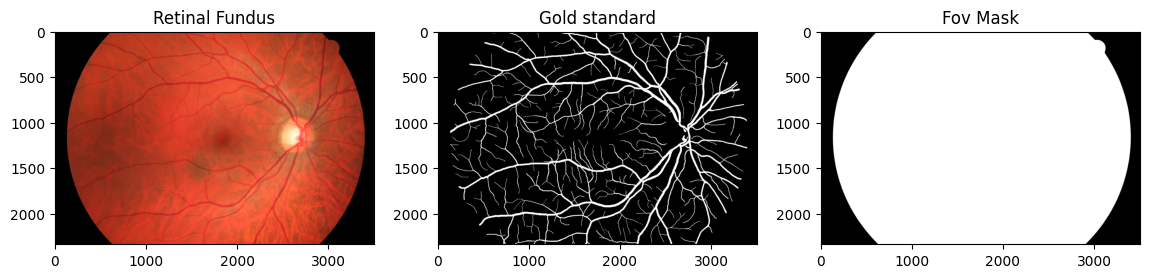

In [58]:
import random

sample_names = get_all_sample_names()
TRAIN_SAMPLE_NAMES = sample_names[:6]
BENCHMARK_SAMPLE_NAMES = sample_names[-3:]

print(f"{TRAIN_SAMPLE_NAMES = }")
print(f"{BENCHMARK_SAMPLE_NAMES = }")

# test_samples = random.cho(sample_names, N_TEST_IMAGES)
test_sample = TRAIN_SAMPLE_NAMES[2]
print(f"Loading test sample: {test_sample}")

image, gs, fov = load_sample_data(sample_name=test_sample)
plt_show_sample(image, gs, fov)

### Generating sample data

In [38]:

tile_centers = list(generate_tile_centers(
    image=image, fov_mask=fov, 
    overlapping=TILE_OVERLAPPING, tile_size=TILE_SIZE
))
positive_tile_centers = []
negative_tile_centers = []

for (row, col) in tile_centers:
    if gs[row, col] > 0:
        positive_tile_centers.append((row, col))
    else:
        negative_tile_centers.append((row, col))

print(f"Positive: {len(positive_tile_centers)}")
print(f"Negative: {len(negative_tile_centers)}")

pos_coords = random.sample(positive_tile_centers, N_POSITIVE_SAMPLES_PER_IMAGE)
neg_coords = random.sample(negative_tile_centers, N_NEGATIVE_SAMPLES_PER_IMAGE)

print(f"Positive: {len(pos_coords)}")
print(f"Negative: {len(neg_coords)}")

test_coords = pos_coords + neg_coords
random.shuffle(test_coords)

for (row, col) in test_coords[:5]:
    print(row, col, gs[row, col])

Positive: 139660
Negative: 1586532
Positive: 400
Negative: 600
1938 3076 0
1100 3298 255
656 2210 0
1694 548 0
1658 422 0


green_avg = 0.24047058823529413
green_std = 0.026683270494073624
r/c: 1648, 2534
values[r,c]: [ 44  59 221], 255
x = array([2.40470588e-01, 2.66832705e-02, 6.66920905e-01, 1.94666408e-05,
       5.39472983e-04, 7.79939177e-04, 5.01292527e-07, 3.42618996e-06,
       6.82195061e-08])
y = 1


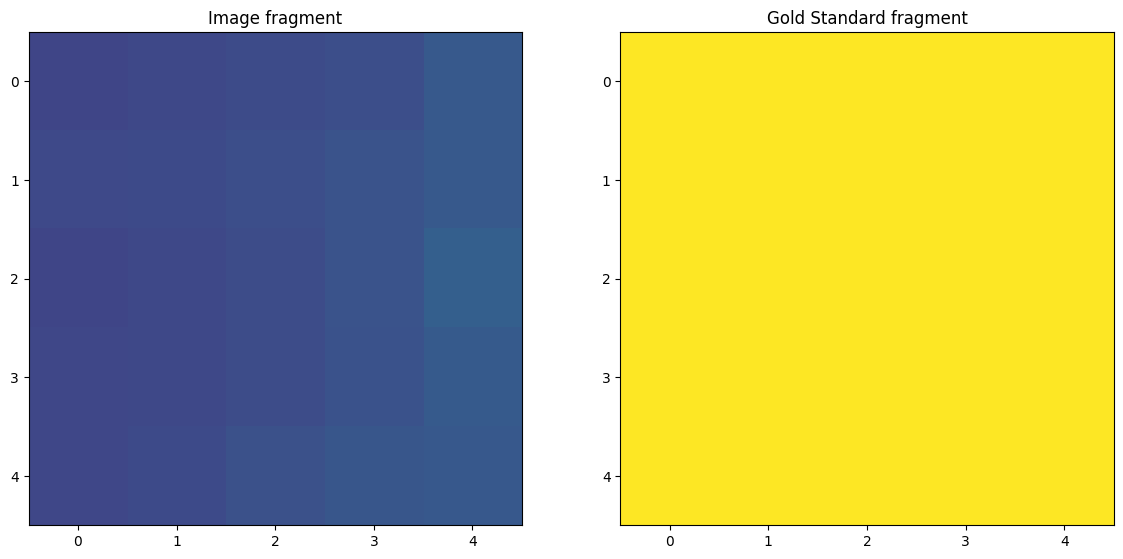

In [59]:
# Example to show where center meets vessel
while True:
    row, col = random.choice(test_coords)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    x, y = extract_tile_features(image=image_rgb, gold_standard=gs, center=(row, col), tile_size=TILE_SIZE, debug=False)
    
    if y == 1:
        break

x, y = extract_tile_features(image=image_rgb, gold_standard=gs, center=(row, col), tile_size=TILE_SIZE, debug=True)
print(f"r/c: {row}, {col}")
print(f"values[r,c]: {image[row, col]}, {gs[row, col]}")
print(f"{x = }")
print(f"{y = }")


In [54]:
X = []
y = []
for row, col in test_coords:
    x, decision = extract_tile_features(image=image, gold_standard=gs, center=(row, col), tile_size=TILE_SIZE)
    X.append(x)
    y.append(decision)

print(X[0])
print(y[0])

[1.51058824e-01 4.16794675e-03 1.06450386e+00 1.19338541e-04
 6.48209033e-05 7.53017781e-05 1.41972989e-09 2.66134889e-07
 5.06577895e-09]
0


### Generowanie Zbioru

In [60]:
from tqdm import tqdm

def generate_image_X_y(sample_name: str, tile_size: int, tiles_per_image: int, pos_neg_ratio: float, overlapping: bool):
    image, gs, fov = load_sample_data(sample_name)

    tile_centers = list(generate_tile_centers(
        image=image, fov_mask=fov, 
        overlapping=overlapping, tile_size=tile_size
    ))
    positive_tile_centers = []
    negative_tile_centers = []

    for (row, col) in tile_centers:
        if gs[row, col] > 0:
            positive_tile_centers.append((row, col))
        else:
            negative_tile_centers.append((row, col))

    # print(f"Positive: {len(positive_tile_centers)}")
    # print(f"Negative: {len(negative_tile_centers)}")

    n_positive_tiles = int(tiles_per_image * pos_neg_ratio)
    n_negative_tiles = tiles_per_image - n_positive_tiles
    assert n_negative_tiles > 0 and n_positive_tiles > 0

    pos_coords = random.sample(positive_tile_centers, n_positive_tiles)
    neg_coords = random.sample(negative_tile_centers, n_negative_tiles)

    # print(f"Positive: {len(pos_coords)}")
    # print(f"Negative: {len(neg_coords)}")

    test_coords = pos_coords + neg_coords
    random.shuffle(test_coords)
    
    X = []
    y = []
    for row, col in test_coords:
        x, decision = extract_tile_features(
            image=image, gold_standard=gs, 
            center=(row, col), tile_size=tile_size
        )
        X.append(x)
        y.append(decision)
    return (X, y)
    
def bulk_generate_X_y(sample_names: List[str], tile_size: int, n_tiles_all: int, pos_neg_ratio: float, overlapping: bool):
    X = []
    y = []
    assert len(sample_names) > 0

    n_tiles_per_image = n_tiles_all // len(sample_names)
    n_tiles_mod = n_tiles_all % len(sample_names)

    for i, sample_name in enumerate(tqdm(sample_names)):
        # split samples in a way that they sum up to n_tiles_all
        # even if divides with reminder
        n_tiles = n_tiles_per_image + (1 if i < n_tiles_mod else 0)
        new_X, new_y = generate_image_X_y(sample_name, tile_size, n_tiles, pos_neg_ratio, overlapping)
        X.extend(new_X)
        y.extend(new_y)
    return (X, y)
        


In [61]:
TILE_SIZE = 5 # must be odd
assert TILE_SIZE % 2 == 1

N_TEST_IMAGES = 6
N_SAMPLES = 100000
POS_NEG_RATIO = 0.4
TILE_OVERLAPPING = True

# test_samples = random.sample(TRAIN_SAMPLE_NAMES, N_TEST_IMAGES)
test_samples = TRAIN_SAMPLE_NAMES[:N_TEST_IMAGES]
print(test_samples)
X, y = bulk_generate_X_y(test_samples, TILE_SIZE, N_SAMPLES, POS_NEG_RATIO, TILE_OVERLAPPING)
assert len(X) == N_SAMPLES

['01_dr', '01_g', '01_h', '02_dr', '02_g', '02_h']


100%|██████████| 6/6 [01:00<00:00, 10.15s/it]


100000
100000


In [62]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
# TODO: co to stratified sampling? i jak to tutaj zrobić?

## Undersampling

In [63]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# nie robimy, bo był wcześniej już
# rus = RandomUnderSampler(random_state=42)
print(f"Classes counts: {Counter(y)}")
# X_res, y_res = rus.fit_resample(X, y)
# print(f"After sampling: {Counter(y_res)}")


Classes counts: Counter({0: 60004, 1: 39996})


## Support Vector Machine

In [45]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_res, y_res)
y_pred = svc.predict(X_test)

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

clf = RandomForestClassifier()
parameters= { 
    'n_estimators': [500, 600],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [7,8,9,10,11],
    'criterion' :['gini', 'entropy']
}
random_src = RandomizedSearchCV(estimator=clf, param_distributions = parameters,
                               cv = 5, n_iter = 10, n_jobs=-1, verbose=1)

In [65]:
random_src.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [7, 8, 9, 10, 11],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [500, 600]},
                   verbose=1)

In [66]:
model = random_src.best_estimator_
random_src.best_params_

{'n_estimators': 600,
 'max_features': 'log2',
 'max_depth': 9,
 'criterion': 'gini'}

In [67]:
import joblib
joblib.dump(random_src, 'random_search_cv.pkl')

['random_search_cv.pkl']

In [68]:
y_pred = random_src.predict(X_test) 

In [69]:
from sklearn.metrics import classification_report

cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.81      0.86      0.83     18003
           1       0.76      0.69      0.73     11997

    accuracy                           0.79     30000
   macro avg       0.79      0.78      0.78     30000
weighted avg       0.79      0.79      0.79     30000



## Dla całego zdjęcia

In [22]:
test_sample = sample_names[-1] 
image, gs, fov = load_sample_data(test_sample)

In [23]:
from tqdm import tqdm
print("...Generating tile centers")
tile_center_coords = list(generate_tile_centers(image=image, fov_mask=fov, overlapping=True, tile_size=TILE_SIZE))
print("...Extracting tile features")

test_image_features = []
for i, (row, col) in enumerate(tqdm(tile_center_coords)):
    x, _ = extract_tile_features(image=image, gold_standard=gs, center=(row, col), tile_size=TILE_SIZE)
    test_image_features.append(x)

...Generating tile centers
...Extracting tile features


100%|██████████| 1725903/1725903 [05:12<00:00, 5514.63it/s]


In [30]:

rnd_src = joblib.load("random_search_cv.pkl")
classifier = rnd_src.best_estimator_
print(rnd_src.best_params_)
print(rnd_src.best_esimator_)



{'n_estimators': 500, 'max_features': 'auto', 'max_depth': 8, 'criterion': 'gini'}


In [31]:
print("...Using classifier")
test_image_predictions = classifier.predict(test_image_features)

...Using classifier


In [25]:
print(f"...Making mask from predicitons {Counter(test_image_predictions)}")
mask = np.zeros_like(fov)
# mask = np.where(test_image_predictions == 1, mask, 255)
for i, (row, col) in enumerate(tqdm(tile_center_coords)):
    if test_image_predictions[i]: mask[row, col] = 255


...Making mask from predicitons Counter({0: 1621023, 1: 104880})


100%|██████████| 1725903/1725903 [00:00<00:00, 1861300.34it/s]


...Comparing gold standard to mask
Accuracy: 59.12%
Sensitivity: 99.43%
Specificity: 9.67%
Mean(spec, sens): 54.55%
GeoMean(spec, sens): 31.01%


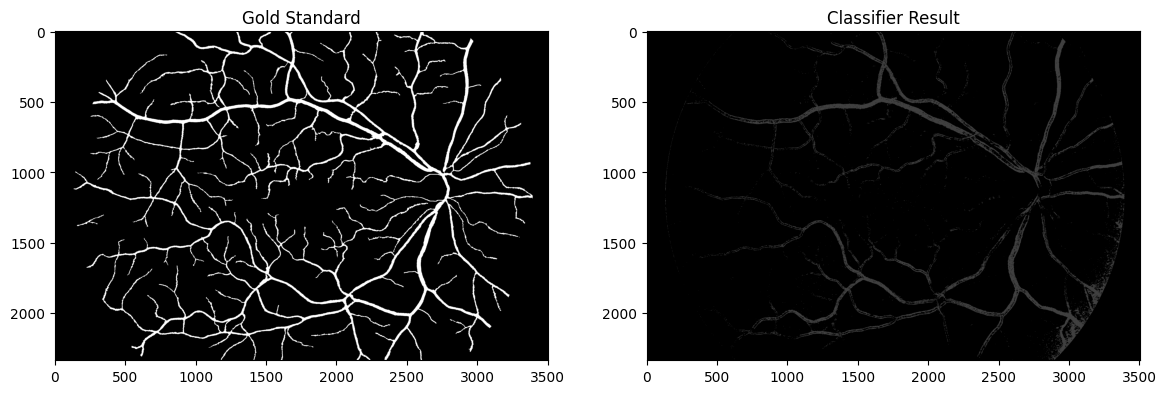

In [26]:
print("...Comparing gold standard to mask")
plt_compare_two_images(gs, mask, grayscale=True, title1="Gold Standard", title2="Classifier Result")
print_statistics(gs, mask)